In [2]:
import pandas as pd

from pathlib import Path

TURBINE_DATA = Path("../data/raw/scada_2020/Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv")
TURBINE_STATUS = Path("../data/raw/scada_2020/Status_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv")

status = pd.read_csv(
    TURBINE_DATA,
    sep=",",
    encoding="utf-8",
    on_bad_lines="skip"
) 

status.head()

,# This file was exported by Greenbyte at 2022-01-27 22:53:20. Please see https://www.greenbyte.com for more information about Greenbyte.
0,#
1,# Turbine: Kelmarsh 1
2,# Turbine type: Senvion MM92
3,# Time zone: UTC
4,# Time interval: 2020-01-01 00:00:00 - 2021-01...


In [ ]:
status = pd.read_csv(
    TURBINE_STATUS,
    sep=",",
    encoding="utf-8",
    on_bad_lines="skip"
) 
status.head()

,# This file was exported by Greenbyte at 2022-01-27 23:29:26. Please see https://www.greenbyte.com for more information about Greenbyte.
0,#
1,# Turbine: Kelmarsh 1
2,# Turbine type: Senvion MM92 (Senvion MM92 kW)
3,# Time zone: UTC
4,# Time interval: 2020-01-01 00:00:00 - 2021-01...


In [14]:
import pandas as pd

data = pd.read_csv(
    TURBINE_DATA,
    skiprows=9,
    header=0,
    sep=",",
    encoding="utf-8",
    low_memory=False,
    on_bad_lines="skip"
)

data.columns = [c.lstrip("# ").strip() for c in data.columns]

info_data = pd.DataFrame({
    "column": data.columns,
    "dtype": data.dtypes.astype(str),
    "n_nulls": data.isna().sum(),
    "n_unique": [data[c].nunique(dropna=True) for c in data.columns]
}).reset_index(drop=True)

print(info_data)

                                       column    dtype  n_nulls  n_unique
0                               Date and time   object        0     52704
1                            Wind speed (m/s)  float64      468     52133
2        Wind speed, Standard deviation (m/s)  float64      722     51978
3                   Wind speed, Minimum (m/s)  float64      722     32526
4                   Wind speed, Maximum (m/s)  float64      722     34088
..                                        ...      ...      ...       ...
294     Drive train acceleration, Max (mm/ss)  float64     4396     48203
295     Drive train acceleration, Min (mm/ss)  float64     4396     48204
296  Drive train acceleration, StdDev (mm/ss)  float64     4396         7
297      Tower Acceleration X, StdDev (mm/ss)  float64     4383     48317
298      Tower Acceleration Y, StdDev (mm/ss)  float64     4383     48317

[299 rows x 4 columns]


In [39]:
# get data info (skipping first rows which are metadata)
status = pd.read_csv(
    TURBINE_STATUS,
    sep=",",
    encoding="utf-8",
    skiprows=9,
    header=0,
    on_bad_lines="skip",
)

status.columns = [c.lstrip("# ").strip() for c in status.columns]

info_status = pd.DataFrame({
    "column": status.columns,
    "dtype": status.dtypes.astype(str),
    "n_nulls": status.isna().sum(),
    "n_unique": [status[c].nunique(dropna=True) for c in status.columns]
}).reset_index(drop=True)

print(info_status)

                      column    dtype  n_nulls  n_unique
0            Timestamp start   object        0      6553
1              Timestamp end   object        0      1193
2                   Duration   object        0       181
3                     Status   object        0         4
4                       Code    int64        0        65
5                    Message   object        0        65
6                    Comment  float64     8737         0
7  Service contract category   object     6430        12
8               IEC category   object       63         7


In [41]:
def categorize(col):
    c = col.lower()
    if "wind" in c: return "Wind"
    if "direction" in c or "vane" in c: return "Direction"
    if "power" in c or "energy" in c: return "Power/Energy"
    if "loss" in c or "avail" in c or "capacity" in c: return "Loss/Availability"
    if "temp" in c or "°c" in c: return "Temperature"
    if "volt" in c or "curr" in c or "freq" in c: return "Electrical"
    if "rpm" in c or "speed" in c: return "Speed/Rotation"
    if "pitch" in c or "yaw" in c or "blade" in c: return "Pitch/Yaw"
    if "accel" in c or "vibration" in c: return "Vibration"
    return "Other"

categories = pd.Series({col: categorize(col) for col in data.columns})
categories.value_counts()

Temperature          76
Other                54
Electrical           48
Power/Energy         41
Wind                 22
Pitch/Yaw            16
Loss/Availability    14
Speed/Rotation       12
Vibration            12
Direction             4
Name: count, dtype: int64

In [45]:
temp_cols = [c for c in data.columns if "temperature" in c.lower()]
print(f"{len(temp_cols)} temperature related columns:")
for c in temp_cols[:10]:
    print(" -", c)

68 temperature related columns:
 - Front bearing temperature (°C)
 - Rear bearing temperature (°C)
 - Stator temperature 1 (°C)
 - Nacelle ambient temperature (°C)
 - Nacelle temperature (°C)
 - Transformer temperature (°C)
 - Gear oil inlet temperature (°C)
 - Generator bearing rear temperature (°C)
 - Generator bearing front temperature (°C)
 - Gear oil temperature (°C)


In [4]:
# Convert to datetime and sort
data["Date and time"] = pd.to_datetime(data["Date and time"], utc=True)
data = data.sort_values("Date and time")

# exemplary extraction of temperature features
temp_features = [
    "Front bearing temperature (°C)",
    "Rear bearing temperature (°C)",
    "Stator temperature 1 (°C)",
    "Nacelle ambient temperature (°C)",
    "Nacelle temperature (°C)"
]
temps = data[["Date and time"] + temp_features].dropna()
print(f"Shape: {temps.shape}")

Shape: (51982, 6)


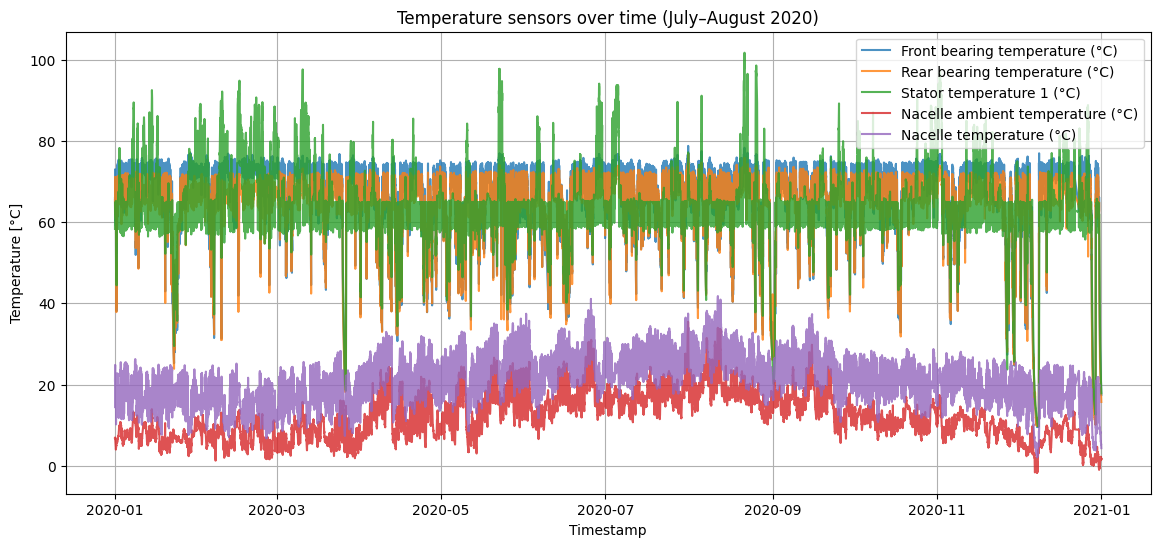

In [ ]:
import matplotlib.pyplot as plt

# visualize temperature features

subset = temps.set_index("Date and time")
plt.figure(figsize=(14,6))
for c in temp_features:
    plt.plot(subset.index, subset[c], label=c, alpha=0.8)
plt.title("Temperature sensors over time (July–August 2020)")
plt.xlabel("Timestamp")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# analyze time differences of timestamps
data["Date and time"] = pd.to_datetime(data["Date and time"], utc=True)
diffs = data["Date and time"].diff().dropna().dt.total_seconds()
print(diffs.describe())

# visualize small irregularities
diffs.value_counts().head(5)

count    52703.0
mean       600.0
std          0.0
min        600.0
25%        600.0
50%        600.0
75%        600.0
max        600.0
Name: Date and time, dtype: float64


Date and time
600.0    52703
Name: count, dtype: int64

In [ ]:
# check missing values --> drop columns with high na ratio
na_ratio = data.isna().mean().sort_values(ascending=False)
na_ratio.head(15)

Potential power met mast anemometer MPC (kW)          1.000000
Lost Production (Contractual Global) (kWh)            1.000000
Potential power met mast anemometer (kW)              1.000000
Production-based Contractual Avail. (Global)          1.000000
Production-based Contractual Avail. (Custom)          1.000000
Time-based Contractual Avail. (Custom)                1.000000
Equivalent Full Load Hours counter (s)                1.000000
Lost Production (Contractual Custom) (kWh)            1.000000
Time-based Contractual Avail. (Global)                1.000000
Reactive Energy Export counter (kvarh)                0.998615
Potential power estimated (kW)                        0.991120
Energy Import counter (kWh)                           0.961369
Production-based IEC B.2.3 (Users View)               0.126006
Lost Production (Production-based IEC B.2.3) (kWh)    0.123937
Energy Export counter (kWh)                           0.111870
dtype: float64

datetime64[ns, UTC]
2020-01-01 00:00:00+00:00 → 2020-12-31 23:50:00+00:00


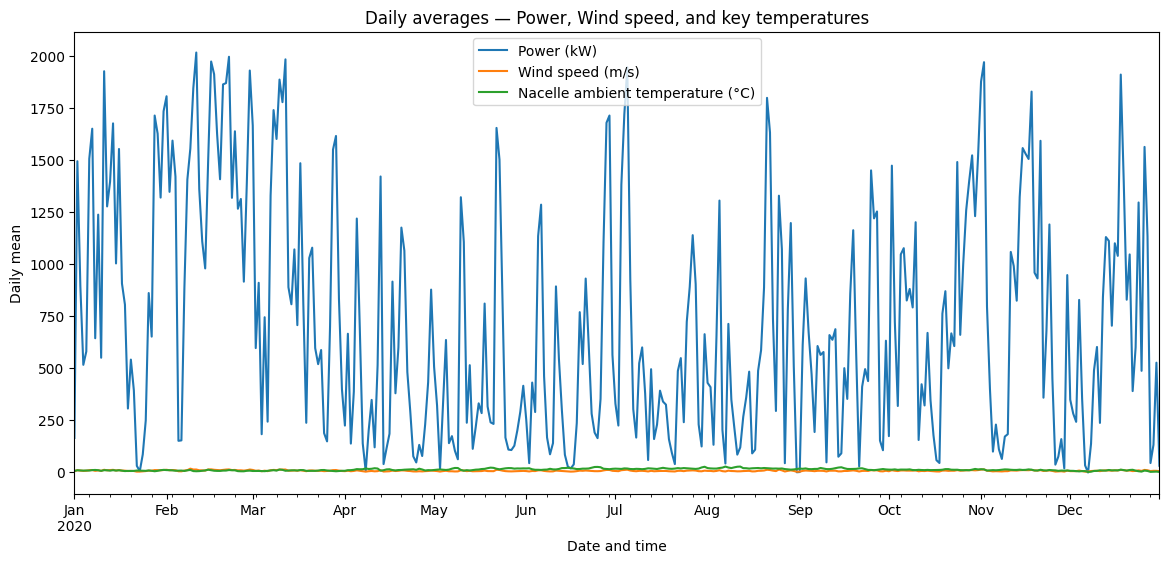

In [15]:
import matplotlib.pyplot as plt

# visualize daily averages of key features

cols = [
    "Power (kW)",
    "Wind speed (m/s)",
    "Nacelle ambient temperature (°C)"
]

# Ensure the datetime column is properly parsed and set as index
data["Date and time"] = pd.to_datetime(data["Date and time"], utc=True, errors="coerce")

# Drop any rows with invalid timestamps
data = data.dropna(subset=["Date and time"])

# Sort chronologically and set as index
data = data.sort_values("Date and time").set_index("Date and time")

print(data.index.dtype)
print(data.index.min(), "→", data.index.max())
data[cols].resample("D").mean().plot(figsize=(14,6))
plt.title("Daily averages — Power, Wind speed, and key temperatures")
plt.ylabel("Daily mean")
plt.show()


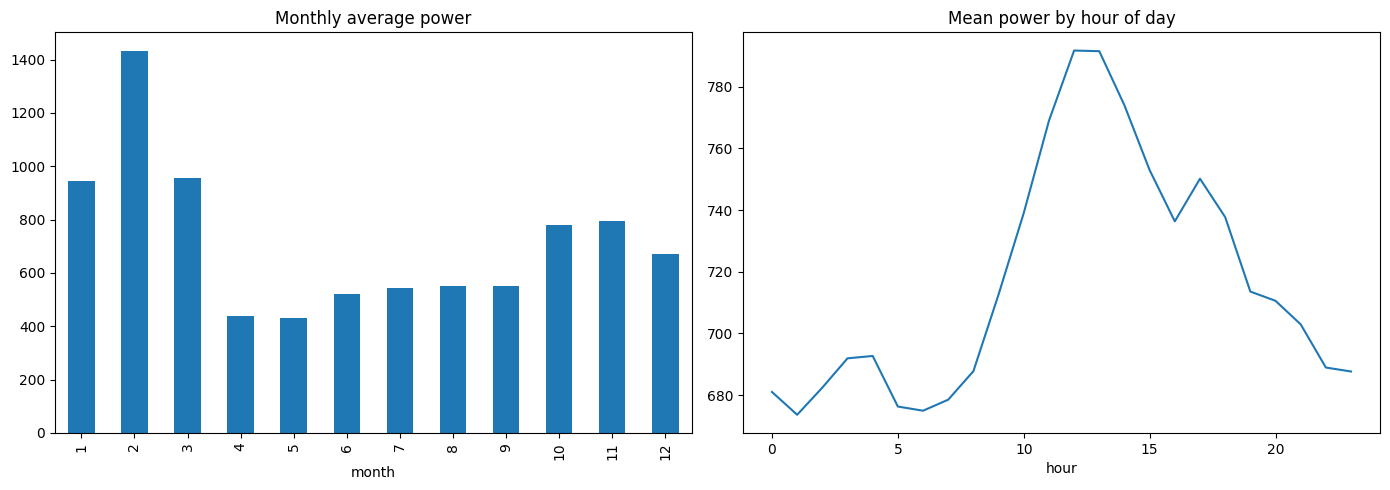

In [16]:
data["month"] = data.index.month
data["hour"] = data.index.hour

fig, ax = plt.subplots(1, 2, figsize=(14,5))
data.groupby("month")["Power (kW)"].mean().plot(kind="bar", ax=ax[0], title="Monthly average power")
data.groupby("hour")["Power (kW)"].mean().plot(ax=ax[1], title="Mean power by hour of day")
plt.tight_layout()
plt.show()

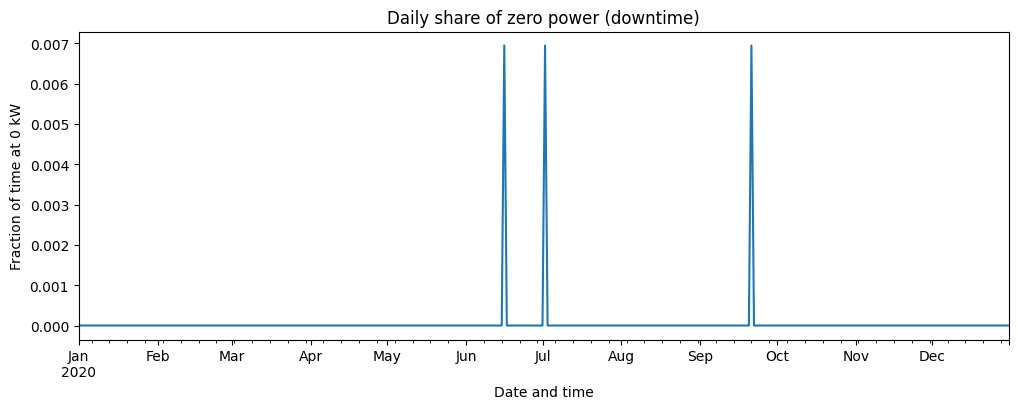

In [ ]:
# check for downtime --> outliers in power data
downtime = (data["Power (kW)"] == 0).resample("D").mean()
downtime.plot(figsize=(12,4), title="Daily share of zero power (downtime)")
plt.ylabel("Fraction of time at 0 kW")
plt.show()


In [ ]:
# find anomalies where power is low but wind speed is high
anomalies = data[
    (data["Wind speed (m/s)"] > 6) &
    (data["Power (kW)"] < 100)
]
print(f"{len(anomalies)} anomalous records detected")


258 anomalous records detected
